## Modelo: Red Neuronal

Importo las librerias que utilizare.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from keras import Sequential
import ipywidgets as widgets
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder,
)
import warnings 
warnings.filterwarnings('ignore')
from keras.metrics import MeanSquaredError
from keras.losses import MeanSquaredError
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    mean_absolute_percentage_error,
)

In [2]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras as keras

### Lectura de archivos

Leo arc Shippings 

In [3]:
ship = pd.read_csv('silkroad_shippings.csv')

Leo arc Reviews

In [4]:
rev = pd.read_csv('silkroad_reviews.csv')

In [5]:
rev = rev[['item_id','rating']]

In [6]:
rev.shape

(314209, 2)

Hay varios ratings asociados al mismo item_id, por lo tanto voy a quedarme con el rating promedio por cada item_id.

In [7]:
grouped_rev = rev.groupby('item_id').agg({'rating':'mean'})

In [8]:
grouped_rev.shape

(12749, 1)

In [9]:
grouped_rev.reset_index(inplace=True)

Realizo el join entre los dos arc que leí.

In [10]:
join = ship.merge(grouped_rev,how='left')

In [11]:
join.shape

(560458, 6)

Modifico el formato del timestamp

In [12]:
# formateo el timestamp del join
join['timestamp'] =pd.to_datetime(join["timestamp"]).dt.strftime('%Y-%m-%d')

Leo el arc de bitcoins

In [13]:
bit = pd.read_csv('bitcoins.csv')

In [14]:
bit['Date'] = pd.to_datetime(bit['Date']).dt.strftime('%Y-%m-%d')

In [15]:
bit = bit[['Date','Price']].rename(columns={'Price':'EuroPrice'})

In [16]:
merge = join.merge(bit,left_on='timestamp',right_on ='Date',how = 'left')

In [17]:
merge['bit_en_euro'] = merge['price']*merge['EuroPrice']

Voy a trabajar con todos los precios del shipping menores o igual a 100 Euros.

In [18]:
#achico mi rango de precios AGREGUE RECIEN
merge = merge[merge['bit_en_euro'] <= 100]

In [19]:
# Libero RAM
del(merge['price'])
del(merge['Date'])
del(merge['EuroPrice'])
del(merge['item_id'])
del join
del ship
del rev
del grouped_rev

In [20]:
merge = merge.sort_values(by='timestamp', ascending=True)

In [21]:
del(merge['timestamp'])

### Realizo la division en train y test.

Tomo el limite para dividir el test del train

In [22]:
index_limite = int(merge.shape[0] * 0.8 )

In [23]:
limite = merge.index[index_limite]

Train

In [24]:
train =  merge[merge.index <= limite]

In [25]:
train.shape

(440527, 4)

In [26]:
trainLabel = train['bit_en_euro']

In [27]:
del(train['bit_en_euro'])

Test

In [28]:
test =  merge[merge.index > limite]

In [29]:
test.shape

(111840, 4)

In [30]:
testLabel = test['bit_en_euro']

In [31]:
del(test['bit_en_euro'])

### Encodings

Diccionario de encodigns

In [32]:
encoding = {}

Funciones para los encodings.

In [33]:
def countVect(df,columna,dic):
    if columna not in dic:
        dic[columna]=Pipeline([('countV', CountVectorizer(max_features =5000)), ('TruncatedSVD', TruncatedSVD(n_components=50, n_iter=3, random_state=0))])
        col_encoded = dic[columna].fit_transform(df[columna].fillna('desconocido'))
    else:
        col_encoded = dic[columna].transform(df[columna].fillna('desconocido'))
    col_encoded = pd.DataFrame(col_encoded).add_prefix(columna+ '_enconded_').fillna(0) #imputacion de nulos
    del(df[columna])
    df_nuevo = pd.concat([df.reset_index(drop=True),col_encoded], axis=1)
    return df_nuevo
    #la imputacion de nulos se realiza reemplazando los mismos por 'desconocido'

In [34]:
def ordinal_enc(df,dic):
    for column in df.columns:
        if df[column].dtypes==object:
            dic[column] = OrdinalEncoder(handle_unknown='ignore')
            df[column] = dic[column].fit_transform(df[column].astype(str).values.reshape(-1, 1))
    if df[column].dtype==object:
        df[column] = dic[column].transform(df[column].astype(str).values.reshape(-1, 1))
    df.fillna(-1,inplace=True) #imputacion de nulos
    return(df)

### Train

In [35]:
train.columns

Index(['description', 'est_delivery', 'rating'], dtype='object')

Realizo los encodings en el train.

In [36]:
train = countVect(train,'description',encoding)

In [37]:
train = ordinal_enc(train,encoding)

Muestro los encoders

In [38]:
encoding

{'description': Pipeline(steps=[('countV', CountVectorizer(max_features=5000)),
                 ('TruncatedSVD',
                  TruncatedSVD(n_components=50, n_iter=3, random_state=0))]),
 'est_delivery': OrdinalEncoder(handle_unknown='ignore')}

### Validation

Realizo los encodings en el validation

In [39]:
test = countVect(test,'description',encoding)

In [40]:
test = ordinal_enc(test,encoding)

#### Trabajo con el modelo

In [41]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

In [42]:
train.shape

(440527, 52)

In [43]:
model = Sequential()
model.add(Dense(50, input_dim=52, activation='tanh'))
model.add(tf.keras.layers.Dropout(.2))
model.add(Dense(30, activation='tanh'))
model.add(tf.keras.layers.Dropout(.2))
model.add(Dense(30, activation='tanh'))
model.add(tf.keras.layers.Dropout(.2))
model.add(Dense(30, activation='relu'))
model.add(tf.keras.layers.Dropout(.2))
model.add(Dense(1, activation='relu'))

In [44]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse", metrics=["mae"]) 

Muestro las caracteristicas de la red.

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                2650      
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                1530      
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 30)                9

Creo el objeto de EarlyStopping

In [46]:
stop= EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True) 

### Entreno la red.

In [47]:
# fit the keras model on the dataset
resultado=model.fit(train.values, 
          trainLabel.values,
          epochs=200,
          callbacks=[stop],
          batch_size=4096,
          verbose=2,
          validation_split=0.2,
)

Epoch 1/200
87/87 - 2s - loss: 824.9081 - mae: 9.7535 - val_loss: 187.7428 - val_mae: 9.3590 - 2s/epoch - 18ms/step
Epoch 2/200
87/87 - 1s - loss: 789.0390 - mae: 9.5309 - val_loss: 172.3754 - val_mae: 8.7575 - 817ms/epoch - 9ms/step
Epoch 3/200
87/87 - 1s - loss: 741.6270 - mae: 7.8136 - val_loss: 114.2769 - val_mae: 6.4355 - 727ms/epoch - 8ms/step
Epoch 4/200
87/87 - 1s - loss: 715.5803 - mae: 7.1026 - val_loss: 104.6703 - val_mae: 6.0911 - 797ms/epoch - 9ms/step
Epoch 5/200
87/87 - 1s - loss: 707.7703 - mae: 6.9068 - val_loss: 98.4452 - val_mae: 5.9970 - 808ms/epoch - 9ms/step
Epoch 6/200
87/87 - 1s - loss: 702.8134 - mae: 6.7693 - val_loss: 93.2542 - val_mae: 5.8193 - 817ms/epoch - 9ms/step
Epoch 7/200
87/87 - 1s - loss: 698.2080 - mae: 6.6322 - val_loss: 86.6840 - val_mae: 5.5796 - 793ms/epoch - 9ms/step
Epoch 8/200
87/87 - 1s - loss: 694.0484 - mae: 6.4947 - val_loss: 81.1495 - val_mae: 5.3048 - 754ms/epoch - 9ms/step
Epoch 9/200
87/87 - 1s - loss: 690.1716 - mae: 6.3674 - val_lo

Epoch 71/200
87/87 - 1s - loss: 655.6581 - mae: 5.0288 - val_loss: 48.4071 - val_mae: 3.8347 - 710ms/epoch - 8ms/step
Epoch 72/200
87/87 - 1s - loss: 655.7430 - mae: 5.0262 - val_loss: 47.9021 - val_mae: 3.8175 - 745ms/epoch - 9ms/step
Epoch 73/200
87/87 - 1s - loss: 655.5447 - mae: 5.0075 - val_loss: 47.8471 - val_mae: 3.7979 - 701ms/epoch - 8ms/step
Epoch 74/200
87/87 - 1s - loss: 655.0021 - mae: 4.9989 - val_loss: 47.9070 - val_mae: 3.7683 - 776ms/epoch - 9ms/step
Epoch 75/200
87/87 - 1s - loss: 655.0764 - mae: 4.9966 - val_loss: 47.6619 - val_mae: 3.7491 - 719ms/epoch - 8ms/step
Epoch 76/200
87/87 - 1s - loss: 654.6010 - mae: 4.9914 - val_loss: 47.5601 - val_mae: 3.7620 - 812ms/epoch - 9ms/step
Epoch 77/200
87/87 - 1s - loss: 654.9704 - mae: 4.9933 - val_loss: 47.3255 - val_mae: 3.7459 - 773ms/epoch - 9ms/step
Epoch 78/200
87/87 - 1s - loss: 654.5214 - mae: 4.9721 - val_loss: 47.2627 - val_mae: 3.7421 - 801ms/epoch - 9ms/step
Epoch 79/200
87/87 - 1s - loss: 654.5136 - mae: 4.9806 -

87/87 - 1s - loss: 649.6721 - mae: 4.7548 - val_loss: 44.7400 - val_mae: 3.5842 - 704ms/epoch - 8ms/step
Epoch 141/200
87/87 - 1s - loss: 649.4375 - mae: 4.7406 - val_loss: 44.7280 - val_mae: 3.5521 - 745ms/epoch - 9ms/step
Epoch 142/200
87/87 - 1s - loss: 649.4506 - mae: 4.7508 - val_loss: 44.6839 - val_mae: 3.6150 - 752ms/epoch - 9ms/step
Epoch 143/200
87/87 - 1s - loss: 648.9950 - mae: 4.7455 - val_loss: 44.0883 - val_mae: 3.5459 - 745ms/epoch - 9ms/step
Epoch 144/200
87/87 - 1s - loss: 649.0158 - mae: 4.7381 - val_loss: 44.0284 - val_mae: 3.5696 - 748ms/epoch - 9ms/step
Epoch 145/200
87/87 - 1s - loss: 648.7294 - mae: 4.7290 - val_loss: 43.7864 - val_mae: 3.5375 - 785ms/epoch - 9ms/step
Epoch 146/200
87/87 - 1s - loss: 648.9068 - mae: 4.7426 - val_loss: 43.7889 - val_mae: 3.5746 - 752ms/epoch - 9ms/step
Epoch 147/200
87/87 - 1s - loss: 649.0374 - mae: 4.7349 - val_loss: 43.8988 - val_mae: 3.5645 - 676ms/epoch - 8ms/step
Epoch 148/200
87/87 - 1s - loss: 648.8646 - mae: 4.7359 - val_

### Grafico sobre la loss

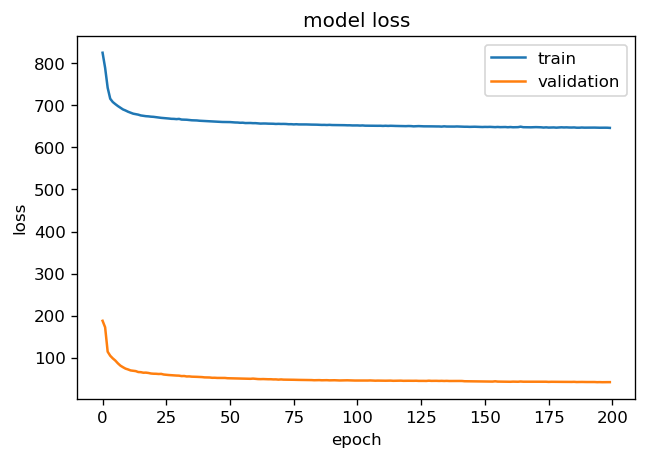

In [48]:
plt.figure(dpi=120)
plt.plot(resultado.history["loss"])
plt.plot(resultado.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")

### Grafico el MAE

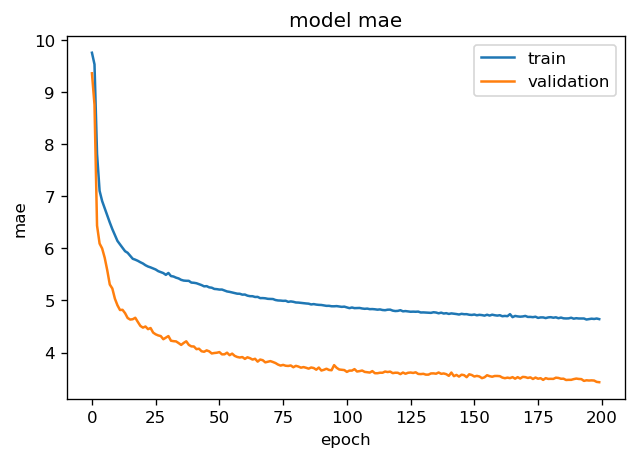

In [49]:
plt.figure(dpi=120)
plt.plot(resultado.history["mae"])
plt.plot(resultado.history["val_mae"])
plt.title("model mae")
plt.ylabel("mae")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")

### Realizo la predicción

In [50]:
y_predict=model.predict(test)

In [51]:
y_predict

array([[ 7.2596197],
       [ 5.3598332],
       [ 5.1809945],
       ...,
       [ 6.748385 ],
       [17.59421  ],
       [21.620079 ]], dtype=float32)

### Calculo de las metricas de medicion
* Error cuadratico medio
* Error absoluto medio

In [52]:
mean_squared_error(testLabel,  y_predict)

56.13087636887935

In [53]:
mean_absolute_error(testLabel,  y_predict)

3.9183013571179277

### Curva de calibracion

In [54]:
r, p = sp.stats.pearsonr(testLabel.to_numpy().flatten(), y_predict.flatten())
r2 = r**2
print('r2: ', r2, ' p: ',p)

r2:  0.7101572586912935  p:  0.0


Text(0.05, 0.9, 'r2=0.71, p=0')

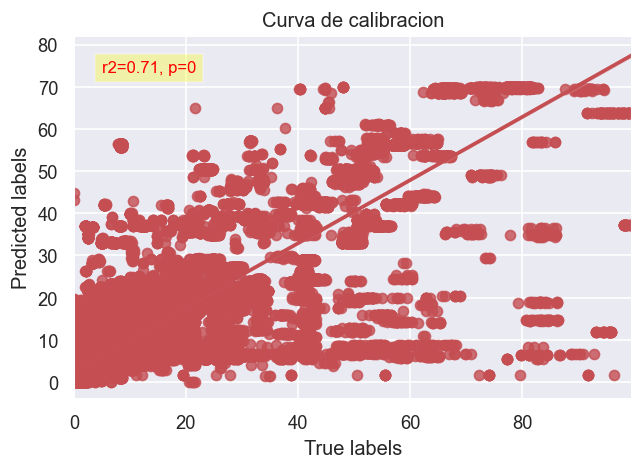

In [55]:
sns.set(rc={"figure.dpi":120})
curvaCalibracion = sns.regplot(testLabel.to_numpy().flatten(), y_predict.flatten(), color='r')
curvaCalibracion.set_xlabel('True labels', fontsize = 12)
curvaCalibracion.set_ylabel('Predicted labels', fontsize = 12)
curvaCalibracion.set_title('Curva de calibracion', fontsize = 12)
curvaCalibracion.text(.05, .9, 'r2={:.2f}, p={:.2g}'.format(r2, p),
            transform=curvaCalibracion.transAxes,fontdict=dict(color='red',size=10),
                      bbox=dict(facecolor='yellow',alpha=0.3))

### Residual Plots

Text(41.87500000000001, 0.5, 'Predicted labels')

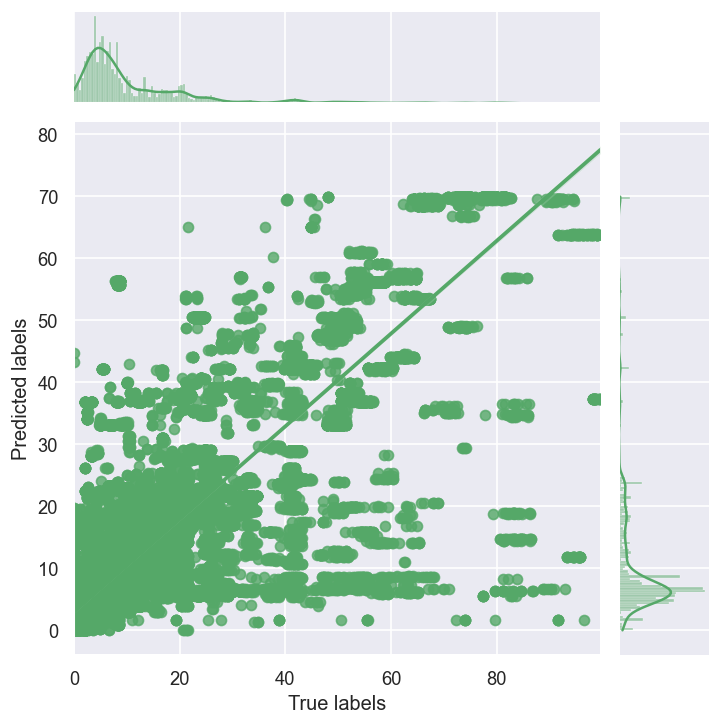

In [56]:
sns.set(rc={"figure.dpi":120})
jointp = sns.jointplot(x = testLabel.values.flatten(), y = y_predict.flatten(), kind="reg", color ='g')
jointp.ax_joint.set_xlabel('True labels', fontsize = 12)
jointp.ax_joint.set_ylabel('Predicted labels', fontsize = 12)
#el de arriba es el label, el del costado es la prediccion

In [57]:
info_histo = (testLabel.to_numpy().flatten()-y_predict.flatten())

Text(0.5, 1.0, 'Distribucion gaussiana del error')

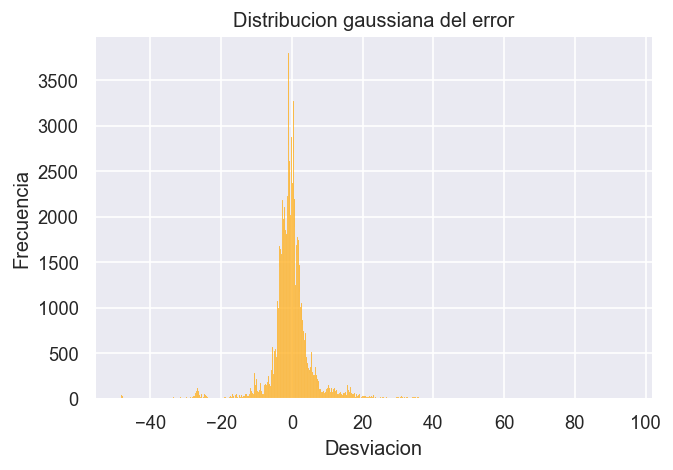

In [58]:
sns.set(rc={"figure.dpi":120})
histo = sns.histplot(x=info_histo, color ='orange')
histo.set_xlabel('Desviacion', fontsize = 12)
histo.set_ylabel('Frecuencia', fontsize = 12)
histo.set_title('Distribucion gaussiana del error', fontsize = 12)